/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Isochrone generation took 1.290784 s.
Making photometry for isochrone: log(t) = 6.00  AKs = 0.70  dist = 4500
     Starting at:  2025-02-11 02:35:24.723540   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F162M = 23.11
Starting filter: jwst,F182M   Elapsed time: 0.60 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F182M = 23.10
Starting filter: jwst,F200W   Elapsed time: 1.21 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F200W = 22.85
      Time taken: 1.82 seconds
Isochrone generation took 1.146068 s.
Making photometry for isochrone: log(t) = 6.18  AKs = 0.70  dist = 4500
     Starting at:  2025-02-11 02:35:27.712440   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2292 K  m_jwst_F162M = 23.47
Starting filter: jwst,F182M   Elapsed time: 0.6

Starting filter: jwst,F200W   Elapsed time: 1.25 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1814 K  m_jwst_F200W = 24.78
      Time taken: 1.85 seconds
Changing to logg=5.00 for T=  1773 logg=4.01
Isochrone generation took 1.126344 s.
Making photometry for isochrone: log(t) = 6.88  AKs = 0.70  dist = 4500
     Starting at:  2025-02-11 02:36:03.585003   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F162M = 25.40
Starting filter: jwst,F182M   Elapsed time: 0.59 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F182M = 25.31
Starting filter: jwst,F200W   Elapsed time: 1.17 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F200W = 24.89
      Time taken: 1.78 seconds
Changing to logg=5.00 for T=  1711 logg=4.02
Isochrone generation took 1.074628 s.
Making photometry for isochrone: log(t) = 6.90  AKs = 0.70  dist = 4500

/tmp/ipykernel_36725/2962280676.py:87: UserWarning: No contour levels were found within the data range.
  contour = plt.contour(level_ages, masses[0], chi_square_values.T, levels=[5.991], colors=['black'], linewidths=2.5)


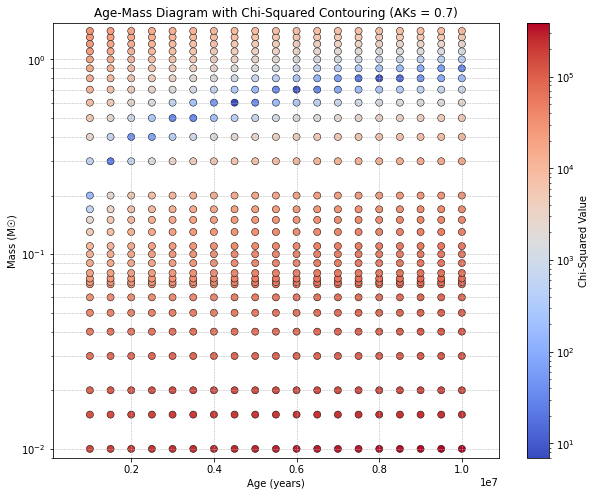

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from spisea import synthetic, evolution, atmospheres, reddening
from spisea.imf import imf, multiplicity
from matplotlib.colors import LogNorm
import csv

# Paths for isochrones and output
iso_dir = 'isochrones/'

# Define isochrone parameters
dist = 4500  # Distance in parsecs
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawCardelli(3.1)
filt_list = ['jwst,F162M', 'jwst,F182M', 'jwst,F200W']
filters = ['m_jwst_F162M', 'm_jwst_F182M', 'm_jwst_F200W']
metallicity = 0
level_ages = np.linspace(1, 10, 19) * 1e6  # Define age array in years
log_age_arr = np.log10(level_ages)
AKs = 0.7  # Extinction value

# Load sample magnitudes and errors
sample_mags, sample_errors = [], []

with open('../../s284.csv', mode='r') as file:
    csvFile = csv.reader(file)
    next(csvFile)  # Skip header row
    for line in csvFile:
        sample_mags.append([float(line[1]), float(line[3]), float(line[5])])  # Extract F162M, F182M, F200W
        sample_errors.append([float(line[2]), float(line[4]), float(line[6])])  # Extract corresponding errors

sample_mags = np.array(sample_mags)
sample_errors = np.array(sample_errors)

# Chi-square function accounting for errors
def chi_square_with_errors(iso_grid, obs_mags, obs_errors):
    chi_square_grid = np.zeros((len(iso_grid), len(iso_grid[0].points)))
    for i, iso in enumerate(iso_grid):
        for j, star in enumerate(iso.points):
            chi_square_grid[i, j] = sum(
                ((obs_mags[k] - star[filters[k]]) ** 2) / (obs_errors[k] ** 2)
                for k in range(len(obs_mags)) if obs_errors[k] > 0
            )
    return chi_square_grid

# Ensure directories exist
os.makedirs(iso_dir, exist_ok=True)

# Clear previous isochrones
for file in os.listdir(iso_dir):
    os.remove(os.path.join(iso_dir, file))

# Generate isochrone grid
instances = np.array([
    synthetic.IsochronePhot(log_age, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                            iso_dir=iso_dir)
    for log_age in log_age_arr
])

# Compute chi-square values for each point, accounting for errors
chi_square_values = chi_square_with_errors(instances, sample_mags[0], sample_errors[0])

# Extract mass values for each isochrone
masses = np.array([[star['mass'] for star in iso.points] for iso in instances])

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
norm = LogNorm(vmin=max(np.min(chi_square_values), 1e-3), vmax=np.max(chi_square_values))
cmap = plt.get_cmap('coolwarm')

# Scatter plot with chi-square gradient
sc = ax.scatter(
    np.repeat(level_ages, chi_square_values.shape[1]), 
    masses.flatten(), c=chi_square_values.flatten(), cmap=cmap, norm=norm, s=50, edgecolor='k', linewidth=0.5
)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Chi-Squared Value')

# Apply logarithmic scale to y-axis
ax.set_yscale('log')

# Contour plot for chi-square threshold
contour = plt.contour(level_ages, masses[0], chi_square_values.T, levels=[5.991], colors=['black'], linewidths=2.5)
ax.clabel(contour, inline=True, fontsize=12)

# Labels and styling
ax.set_xlabel('Age (years)')
ax.set_ylabel('Mass (M☉)')
ax.set_title(f'Age-Mass Diagram with Chi-Squared Contouring (AKs = {AKs})')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Axis padding
x_padding = 0.1 * (level_ages[-1] - level_ages[0])
y_padding_factor = 0.1
ax.set_xlim(level_ages[0] - x_padding, level_ages[-1] + x_padding)
ax.set_ylim(np.min(masses) * (1 - y_padding_factor), np.max(masses) * (1 + y_padding_factor))

plt.show()

In [2]:
# find minimum chi-squared
# table of critical values for a = 0.05, df = 2: 5.991
m = min(chi_square_values[0])
for i in range(len(chi_square_values)):
    for j in range(len(chi_square_values[0])):
        if chi_square_values[i][j] < m:
            m = chi_square_values[i][j]
print(m)

6.977760753670001


Isochrone generation took 1.188178 s.
Making photometry for isochrone: log(t) = 6.00  AKs = 0.60  dist = 4500
     Starting at:  2025-02-11 02:36:22.066427   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F162M = 22.95
Starting filter: jwst,F182M   Elapsed time: 0.60 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F182M = 22.97
Starting filter: jwst,F200W   Elapsed time: 1.22 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F200W = 22.74
      Time taken: 1.83 seconds
Isochrone generation took 1.148673 s.
Making photometry for isochrone: log(t) = 6.18  AKs = 0.60  dist = 4500
     Starting at:  2025-02-11 02:36:25.062426   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2292 K  m_jwst_F162M = 23.31
Starting filter: jwst,F182M   Elapsed time: 0.6

Starting filter: jwst,F200W   Elapsed time: 1.24 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1814 K  m_jwst_F200W = 24.66
      Time taken: 1.85 seconds
Changing to logg=5.00 for T=  1773 logg=4.01
Isochrone generation took 1.152841 s.
Making photometry for isochrone: log(t) = 6.88  AKs = 0.60  dist = 4500
     Starting at:  2025-02-11 02:37:01.262079   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F162M = 25.25
Starting filter: jwst,F182M   Elapsed time: 0.60 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F182M = 25.18
Starting filter: jwst,F200W   Elapsed time: 1.21 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F200W = 24.77
      Time taken: 1.82 seconds
Changing to logg=5.00 for T=  1711 logg=4.02
Isochrone generation took 1.113719 s.
Making photometry for isochrone: log(t) = 6.90  AKs = 0.60  dist = 4500

/tmp/ipykernel_36725/1329290503.py:39: UserWarning: No contour levels were found within the data range.
  contour = plt.contour(level_ages, masses[0], chi_square_values.T, levels=[5.991], colors=['black'], linewidths=2.5)


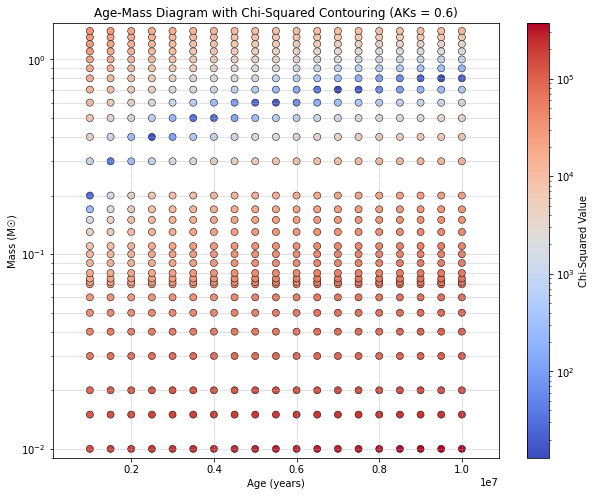

In [3]:
AKs = 0.6  # Extinction value

# Clear previous isochrones
for file in os.listdir(iso_dir):
    os.remove(os.path.join(iso_dir, file))

# Generate isochrone grid
instances = np.array([
    synthetic.IsochronePhot(log_age, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                            iso_dir=iso_dir)
    for log_age in log_age_arr
])

# Compute chi-square values for each point, accounting for errors
chi_square_values = chi_square_with_errors(instances, sample_mags[0], sample_errors[0])

# Extract mass values for each isochrone
masses = np.array([[star['mass'] for star in iso.points] for iso in instances])

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
norm = LogNorm(vmin=max(np.min(chi_square_values), 1e-3), vmax=np.max(chi_square_values))
cmap = plt.get_cmap('coolwarm')

# Scatter plot with chi-square gradient
sc = ax.scatter(
    np.repeat(level_ages, chi_square_values.shape[1]), 
    masses.flatten(), c=chi_square_values.flatten(), cmap=cmap, norm=norm, s=50, edgecolor='k', linewidth=0.5
)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Chi-Squared Value')

# Apply logarithmic scale to y-axis
ax.set_yscale('log')

# Contour plot for chi-square threshold
contour = plt.contour(level_ages, masses[0], chi_square_values.T, levels=[5.991], colors=['black'], linewidths=2.5)
ax.clabel(contour, inline=True, fontsize=12)

# Labels and styling
ax.set_xlabel('Age (years)')
ax.set_ylabel('Mass (M☉)')
ax.set_title(f'Age-Mass Diagram with Chi-Squared Contouring (AKs = {AKs})')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Axis padding
x_padding = 0.1 * (level_ages[-1] - level_ages[0])
y_padding_factor = 0.1
ax.set_xlim(level_ages[0] - x_padding, level_ages[-1] + x_padding)
ax.set_ylim(np.min(masses) * (1 - y_padding_factor), np.max(masses) * (1 + y_padding_factor))

plt.show()

In [5]:
m = min(chi_square_values[0])
for i in range(len(chi_square_values)):
    for j in range(len(chi_square_values[0])):
        if chi_square_values[i][j] < m:
            m = chi_square_values[i][j]
print(m)

12.999347811501845


Isochrone generation took 1.232579 s.
Making photometry for isochrone: log(t) = 6.00  AKs = 0.80  dist = 4500
     Starting at:  2025-02-11 02:38:07.687714   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F162M = 23.26
Starting filter: jwst,F182M   Elapsed time: 0.61 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F182M = 23.23
Starting filter: jwst,F200W   Elapsed time: 1.22 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F200W = 22.97
      Time taken: 1.84 seconds
Isochrone generation took 1.161529 s.
Making photometry for isochrone: log(t) = 6.18  AKs = 0.80  dist = 4500
     Starting at:  2025-02-11 02:38:10.704893   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2292 K  m_jwst_F162M = 23.62
Starting filter: jwst,F182M   Elapsed time: 0.6

Starting filter: jwst,F200W   Elapsed time: 1.22 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1814 K  m_jwst_F200W = 24.89
      Time taken: 1.82 seconds
Changing to logg=5.00 for T=  1773 logg=4.01
Isochrone generation took 1.142002 s.
Making photometry for isochrone: log(t) = 6.88  AKs = 0.80  dist = 4500
     Starting at:  2025-02-11 02:38:46.886310   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F162M = 25.56
Starting filter: jwst,F182M   Elapsed time: 0.61 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F182M = 25.44
Starting filter: jwst,F200W   Elapsed time: 1.21 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1773 K  m_jwst_F200W = 25.00
      Time taken: 1.82 seconds
Changing to logg=5.00 for T=  1711 logg=4.02
Isochrone generation took 1.108490 s.
Making photometry for isochrone: log(t) = 6.90  AKs = 0.80  dist = 4500

/tmp/ipykernel_36725/2457192728.py:39: UserWarning: No contour levels were found within the data range.
  contour = plt.contour(level_ages, masses[0], chi_square_values.T, levels=[5.991], colors=['black'], linewidths=2.5)


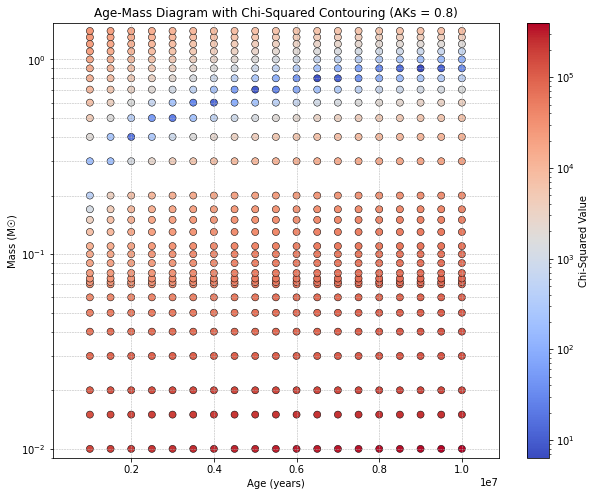

In [6]:
AKs = 0.8  # Extinction value

# Clear previous isochrones
for file in os.listdir(iso_dir):
    os.remove(os.path.join(iso_dir, file))

# Generate isochrone grid
instances = np.array([
    synthetic.IsochronePhot(log_age, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                            iso_dir=iso_dir)
    for log_age in log_age_arr
])

# Compute chi-square values for each point, accounting for errors
chi_square_values = chi_square_with_errors(instances, sample_mags[0], sample_errors[0])

# Extract mass values for each isochrone
masses = np.array([[star['mass'] for star in iso.points] for iso in instances])

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
norm = LogNorm(vmin=max(np.min(chi_square_values), 1e-3), vmax=np.max(chi_square_values))
cmap = plt.get_cmap('coolwarm')

# Scatter plot with chi-square gradient
sc = ax.scatter(
    np.repeat(level_ages, chi_square_values.shape[1]), 
    masses.flatten(), c=chi_square_values.flatten(), cmap=cmap, norm=norm, s=50, edgecolor='k', linewidth=0.5
)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Chi-Squared Value')

# Apply logarithmic scale to y-axis
ax.set_yscale('log')

# Contour plot for chi-square threshold
contour = plt.contour(level_ages, masses[0], chi_square_values.T, levels=[5.991], colors=['black'], linewidths=2.5)
ax.clabel(contour, inline=True, fontsize=12)

# Labels and styling
ax.set_xlabel('Age (years)')
ax.set_ylabel('Mass (M☉)')
ax.set_title(f'Age-Mass Diagram with Chi-Squared Contouring (AKs = {AKs})')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Axis padding
x_padding = 0.1 * (level_ages[-1] - level_ages[0])
y_padding_factor = 0.1
ax.set_xlim(level_ages[0] - x_padding, level_ages[-1] + x_padding)
ax.set_ylim(np.min(masses) * (1 - y_padding_factor), np.max(masses) * (1 + y_padding_factor))

plt.show()

In [ ]:
m = min(chi_square_values[0])
for i in range(len(chi_square_values)):
    for j in range(len(chi_square_values[0])):
        if chi_square_values[i][j] < min:
            m = chi_square_values[i][j]
print(m)